In [7]:
# VaR (Value at Risk): potential maximum loss of a portfolio over a specific time horizon and with a certain confidence level
# A 1-day 95% VaR of $1000 means there is a 5% chance (confidence level ) that your portfolio will lose more than $1000 over the next day
# VaR is the boundary. It tells you the maximum loss you expect to see on a regular day
# ES (Expected Shortfall): average loss within the worst-case scenarios (the tail of the loss distribution)
# ES is the average disaster. It tells you how bad things get, on average, when you cross that boundary
# assumes that the log-returns (R_log) are normally distributed:  random walk, mean, standard deviation scaled for the time horizon
# P/L: positive (gain) or negative (loss)
# define Loss = -P/L where only losses are considered (if focus on the risk of loss)
# Here, keep all info by allowing negative losses
# Monte-Carlo log-returns, convert log-returns to simple return r, and use it to compute VaR and ES
# Plain Monte-Carlo: the integral of a function is its average value multiplied by the volume of the domain 

In [8]:
import numpy as np
# fictional data source: just to practice the math and algorithm :) ----- ideally we should extract this from historic data
# ---- User controls ----
notional_value = 100_000.0   # position value in EUR
horizon_days   = 1           # VaR horizon in trading days
conf_levels    = [0.95, 0.99]
n_sims         = 200_000
rng_seed       = 42
np.random.seed(rng_seed) #  sets a random number generator seed: makes the simulation reproducible

In [9]:
mu_log_daily    = 0.0005   # ≈ 0.05% per day mean
sigma_log_daily = 0.02     # ≈ 2% daily volatility

In [10]:
# -----------------------------------------------
# Section 4: Monte Carlo VaR & ES
# -----------------------------------------------
from numpy.typing import ArrayLike

# 1) Scale daily log-return moments to horizon
mu_log_h    = mu_log_daily * horizon_days
sigma_log_h = sigma_log_daily * np.sqrt(horizon_days)

# 2) Simulate log-returns, convert to simple returns
log_r = np.random.normal(loc=mu_log_h, scale=sigma_log_h, size=n_sims)
r = np.exp(log_r) - 1.0  # simple returns

# 3) Compute P/L and Loss for a long position
pnl  = notional_value * r
loss = -pnl  # positive numbers are losses

# 4) VaR & ES from the empirical loss distribution
def var_es_from_samples(losses: ArrayLike, alpha: float):
    """Return (VaR_alpha, ES_alpha) from sample losses"""
    losses = np.asarray(losses)
    var = np.quantile(losses, alpha)
    tail = losses[losses >= var]
    es = tail.mean() if tail.size > 0 else float('nan')
    return float(var), float(es)

results_mc = {}
for a in conf_levels:
    VaR_a, ES_a = var_es_from_samples(loss, a)
    results_mc[a] = {"VaR": VaR_a, "ES": ES_a}

# Display
for a in conf_levels:
    print(f"[Monte Carlo] {int(a*100)}% VaR = {results_mc[a]['VaR']:.2f}, "
          f"ES = {results_mc[a]['ES']:.2f}")


[Monte Carlo] 95% VaR = 3181.32, ES = 3992.68
[Monte Carlo] 99% VaR = 4493.93, ES = 5137.34


In [11]:
# -----------------------------------------------
# Section 5: Parametric (Normal) VaR/ES (comparison)
# -----------------------------------------------
from scipy.stats import norm

# convert log-return moments to simple-return moments exactly:
def log_to_simple_moments(mu_log, sigma_log):
    # E[r_simple] = exp(mu + 0.5*sigma^2) - 1
    m1  = np.exp(mu_log + 0.5*sigma_log**2) - 1.0
    var = (np.exp(sigma_log**2) - 1.0) * np.exp(2*mu_log + sigma_log**2)
    sdev = np.sqrt(var)
    return float(m1), float(sdev)

mu_simple_daily, sigma_simple_daily = log_to_simple_moments(mu_log_daily, sigma_log_daily)

# Scale to horizon
mu_simple_h    = mu_simple_daily * horizon_days
sigma_simple_h = sigma_simple_daily * np.sqrt(horizon_days)

# Loss ~ Normal(mu_L, sigma_L) where mu_L = -V*mu_r, sigma_L = V*sigma_r
mu_L    = -notional_value * mu_simple_h
sigma_L =  notional_value * sigma_simple_h

results_param = {}
for a in conf_levels:
    z = norm.ppf(a)  # PPF (Percent Point Function): 95% of the data in a standard Normal distribution lies to the left of z
    VaR_a = mu_L + sigma_L * z
    ES_a  = mu_L + sigma_L * norm.pdf(z) / (1.0 - a) # conditional expectation. pdf(z): the height of the bell curve at the z-score
    results_param[a] = {"VaR": float(VaR_a), "ES": float(ES_a)}

# Display
for a in conf_levels:
    print(f"[Parametric]   {int(a*100)}% VaR = {results_param[a]['VaR']:.2f}, "
          f"ES = {results_param[a]['ES']:.2f}")

# here, the paremetric and the Monte-Carlo are close
# in reality, it is difficult to estimate the paremetric distribution

[Parametric]   95% VaR = 3222.32, ES = 4058.70
[Parametric]   99% VaR = 4586.39, ES = 5264.67


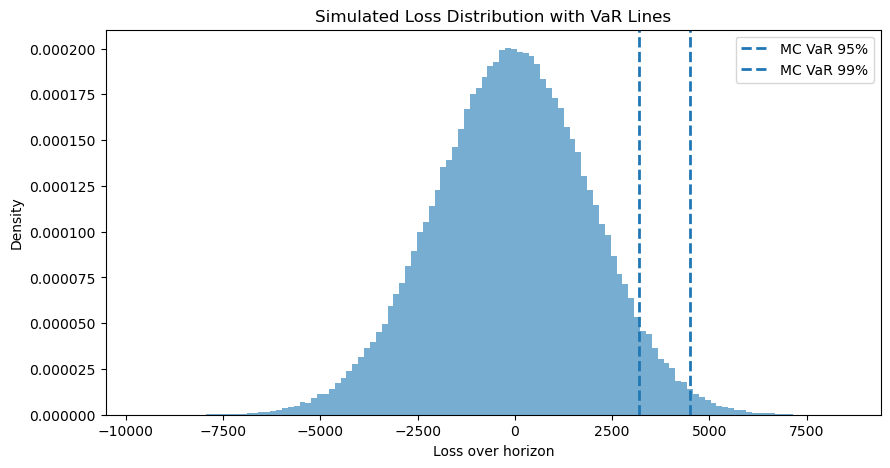

In [12]:
# -----------------------------------------------
# Section 6: Plot Loss histogram with VaR markers
# -----------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(loss, bins=120, density=True, alpha=0.6)
for a in conf_levels:
    plt.axvline(results_mc[a]["VaR"], linestyle="--", linewidth=2, label=f"MC VaR {int(a*100)}%")
plt.title("Simulated Loss Distribution with VaR Lines")
plt.xlabel("Loss over horizon")
plt.ylabel("Density")
plt.legend()
plt.show()
